In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
from numpy import cos, sin
from mpl_toolkits.mplot3d import Axes3D

In [3]:
from scipy.linalg import solve    
import scipy.sparse as sparse
from scipy.sparse.linalg import spsolve 

In [4]:
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

### Parameters

In [5]:
# Number of steps
N = 4

# mu
mu = 1

### Respective Functions

In [6]:
# Solution function U and F

def u(x, y):
    return cos(x)**2 + sin(y)**2

def f(x, y):
    return 2*(cos(x)**2-sin(x)**2+sin(y)**2-cos(y)**2)
    
#def u(x, y):
    #return x**4 + y**4
    
#def f(x, y):
    #return -12*(x**2 + y**2)

In [7]:
# Funnctions representing the circular boundary

def circle_y(x):
    return np.sqrt(1-x**2)

def circle_x(y):
    return np.sqrt(1-y**2)

In [8]:
# Boundaries along the x and y axis

# y = 0
def g_s(x):
    return u(x, 0)

# x = 0
def g_w(y):
    return u(0, y)

In [9]:
# Boundaries along the circle

def g_n(x):
    y = circle_y(x)
    return u(x, y)

def g_e(y):
    x = circle_x(y)
    return u(x, y)

In [10]:
# Distance from boundary

def h_n(x, y):
    return circle_y(x) - y

def h_e(x, y):
    return circle_x(y) - x

In [11]:
def norm(x, y):
    return x**2 + y**2

### Find edges

In [12]:
def east_edge(inner_points, Ni, Ni2):
    array = np.zeros((Ni2), dtype=bool)
    for i in range(Ni2):
        if (inner_points[i] and (i+1)%Ni==0):
            array[i] = True
        elif (inner_points[i] and not inner_points[i+1]):
            array[i] = True
        else:
            array[i] = False
    return array


def north_edge(inner_points, Ni, Ni2):
    array = np.zeros((Ni2), dtype=bool)
    for i in range(Ni2):
        if (inner_points[i] and (i+1) > Ni2-Ni):
            array[i] = True
            
        elif (inner_points[i] and not inner_points[i+Ni]):
            array[i] = True
        else:
            array[i] = False
    return array

### Change Matrix for Edges

In [13]:
def alter_edges(A, b, n_edge_points, e_edge_points, Xi_flat, Yi_flat, Ni, Ni2, h):
    
    # Fill out variable step length 5-point formula for edge points
    for i in range(Ni2):
        
        if (i == (Ni-1) or i == (Ni2-Ni)):
            
            print(i)
            
            x, y = Xi_flat[i], Yi_flat[i]
            hn = h_n(x, y)
            he = h_e(x, y)

            a_p = 2*mu*(1/(h*he) + 1/(h*hn))
            a_e = -2*mu*(1/(h*he+he**2))
            a_w = -2*mu*(1/(h**2+he*h))
            a_n = -2*mu*(1/(h*hn+hn**2))
            a_s = -2*mu*(1/(h**2+hn*h))
            
            A[i, i] = a_p
            
            if (i == (Ni-1)):
                
                A[i, i-1] = a_w

                A[i, i+Ni] = a_n
                
                b[i] = b[i] - a_e*g_e(y) - a_s*g_s(x)
                
            
            elif (i == (Ni2-Ni)):
                
                A[i, i+1] = a_e

                A[i, i-Ni] = a_s
                
                b[i] = b[i] - a_n*g_n(x) - a_w*g_w(y)
            
        
        else:
            
            if (n_edge_points[i] or e_edge_points[i]):

                x, y = Xi_flat[i], Yi_flat[i]
                hn = h_n(x, y)
                he = h_e(x, y)

                a_p = 2*mu*(1/(h*he) + 1/(h*hn))
                a_e = -2*mu*(1/(h*he+he**2))
                a_w = -2*mu*(1/(h**2+he*h))
                a_n = -2*mu*(1/(h*hn+hn**2))
                a_s = -2*mu*(1/(h**2+hn*h))


            if (n_edge_points[i] and e_edge_points[i]):

                A[i, i] = a_p      

                if (i-1 > -1):
                    A[i, i-1] = a_w

                if (i-Ni > -1):
                    A[i, i-Ni]= a_s

                b[i] = b[i] - a_n*g_n(x) - a_e*g_e(y)



            elif (n_edge_points[i]):

                A[i, i] = a_p

                if (i+1 < Ni2):
                    A[i, i+1] = a_e

                if (i-1 > -1):
                    A[i, i-1] = a_w

                if (i-Ni > -1):
                    A[i, i-Ni] = a_s

                b[i] = b[i] - a_n*g_n(x)



            elif (e_edge_points[i]):

                A[i, i] = a_p

                if (i-1 > -1):
                    A[i, i-1] = a_w

                if (i+Ni < Ni2):
                    A[i, i+Ni] = a_n

                if (i-Ni > -1):
                    A[i, i-Ni] = a_s

                b[i] = b[i] - a_e*g_e(y)
            
            
    return A, b

### Build Diagonal Matrix

In [14]:
def A_and_b(h, mu, Ni, Ni2, N, x, y):
    
    
    # Inner points
    xi = x[1:-1]       
    yi = y[1:-1] 
    Xi, Yi = np.meshgrid(xi, yi)
    X, Y = np.meshgrid(x, y)
    Xi_flat, Yi_flat = Xi.flatten(), Yi.flatten()
    
    #V1 = v1(Xi, Yi)
    #V2 = v2(Xi, Yi)
    
    
    # Find edge points
    inner_points = (norm(Xi, Yi) < 1).flatten()
    
    n_edge_points = north_edge(inner_points, Ni, Ni2)
    e_edge_points = east_edge(inner_points, Ni, Ni2)
    

    #print(inner_points.reshape((Ni,Ni)))
    #print(edge_points.reshape((Ni,Ni)))
    
    
    # Coefficients
    #a_p = (4 * mu) / h**2
    #a_e = (- mu/h**2 + V1/(2*h)).flatten()
    #a_n = (- mu/h**2 + V2/(2*h)).flatten()
    #a_w = (- mu/h**2 - V1/(2*h)).flatten()
    #a_s = (- mu/h**2 - V2/(2*h)).flatten()
    
    a_p = ((4 * mu) / h**2)*np.ones(Ni2)
    a_e = (- mu/h**2)*np.ones(Ni2)
    a_n = (- mu/h**2)*np.ones(Ni2)
    a_w = (- mu/h**2)*np.ones(Ni2)
    a_s = (- mu/h**2)*np.ones(Ni2)
    
    
    # Add diagonals
    diag = a_p * np.ones(Ni2)
    A = np.diag(diag)
    
    diag1 = np.arange(Ni2-1)
    A[diag1, diag1+1] = a_e[0:Ni2-1]
    A[diag1+1, diag1] = a_w[1:Ni2]
    
    diag2 = np.arange(Ni2-Ni)
    A[diag2, diag2+Ni] = a_n[0:Ni2-Ni]
    A[diag2+Ni, diag2] = a_s[Ni:Ni2]
    
    
    # Fill inn b vector
    b = np.zeros(Ni2)
    for j in range(Ni):
        for i in range(Ni):
            b[j*Ni + i] = f(xi[i], yi[j])
            
    # Coefficients edges
    #a_e_edge = (- mu/h**2 + V1_e/(2*h)).flatten()
    #a_n_edge = (- mu/h**2 + V2_n/(2*h)).flatten()
    #a_w_edge = (- mu/h**2 - V1_w/(2*h)).flatten()
    #a_s_edge = (- mu/h**2 - V2_s/(2*h)).flatten()
    
    a_w_edge = (- mu/h**2)
    a_s_edge = (- mu/h**2)
    
    
    # Include the boundary conditions on x=0 and y=0
    b[0:Ni] = b[0:Ni] - a_s_edge*g_s(xi)                        # y=0
    b[0:Ni2:Ni] = b[0:Ni2:Ni] - a_w_edge*g_w(yi)                # x=0
    
    b[Ni-1] = b[Ni-1] + a_s_edge*g_s(xi[-1])                    # y=0
    b[Ni2-Ni] = b[Ni2-Ni] + a_w_edge*g_w(yi[-1])                # x=0
    
    
    # Alter A and b for circle edges
    A, b = alter_edges(A, b, n_edge_points, e_edge_points, Xi_flat, Yi_flat, Ni, Ni2, h)
    
    
    # Handle interior stack-edges
    for i in range(1, Ni):
        edge = i*Ni
        A[edge-1, edge] = 0
        A[edge, edge-1] = 0
    
    
    #V2_s = v2(X[0,1:-1], Y[0, 1:-1])
    #V1_w = v1(X[1:-1,0], Y[1:-1, 0])
    #V2_n = v2(X[N,1:-1], Y[N, 1:-1])
    #V1_e = v1(X[1:-1,N], Y[1:-1, N])
    
    
    
    A = A[inner_points, :]
    A = A[:, inner_points]
    b = b[inner_points]
    
    
    return A, b, inner_points

### Solve Function

In [15]:
def pde_solve(N, mu):
    
    
    # Time run
    start = time.time()
    
    
    # Step size
    h = 1/N
    
    
    # Make grid
    x = np.linspace(0, 1, N+1)
    y = np.linspace(0, 1, N+1) 
    X, Y = np.meshgrid(x, y)
    Ni = N-1       # Number of inner points in each direction
    Ni2 = Ni**2    # Number of inner points in total

    
    # Exact Solution
    U_exact = u(X, Y)
    U_exact[norm(X, Y) > 1] = 0
    
    
    # Create A matrix
    A, b, inner_points = A_and_b(h, mu, Ni, Ni2, N, x, y)
    
    
    # Use sparce matrix format
    A = sparse.csr_matrix(A)
    A = A.tocsr()
    
    
    # Solve system numerically
    U = spsolve(A, b)
    
    
    # Add the edges and set points outside domain to zero
    j = 0
    temp = np.zeros(Ni2)
    for i in range(Ni2):
        if (inner_points[i]):
            temp[i] = U[j]
            j+=1
            
    U = np.reshape(temp, (Ni, Ni))
    
    
    # Add edges to solution
    U = np.pad(U, pad_width=1, mode='constant', constant_values=0)
    U[0, :] = g_s(x)
    U[:, 0] = g_w(y)
    U[norm(X, Y) > 1] = 0
    
    
    error = np.max(np.abs(U-U_exact))
    
    
    #Print the error
    print(f'The steplength is {1}/{N}. The error is: {error}. Runtime total: {time.time()-start}')
    
    
    return U, U_exact, X, Y, h

### Solve System

In [16]:
U, U_exact, X, Y, h = pde_solve(100, mu)

98
9702
The steplength is 1/100. The error is: 1.594702381082157. Runtime total: 4.178781270980835


In [17]:
print(U, U_exact)

[[1.         0.9999     0.99960005 ... 0.31027412 0.30106056 0.29192658]
 [1.0001     1.         0.99970005 ... 0.31029039 0.30102332 0.        ]
 [1.00039995 1.00029995 1.         ... 0.31053639 0.30127827 0.        ]
 ...
 [1.68972588 1.68970961 1.68946361 ... 0.         0.         0.        ]
 [1.69893944 1.69897668 1.69872173 ... 0.         0.         0.        ]
 [1.70807342 0.         0.         ... 0.         0.         0.        ]] [[1.         0.9999     0.99960005 ... 0.31027412 0.30106056 0.29192658]
 [1.0001     1.         0.99970005 ... 0.31037411 0.30116056 0.        ]
 [1.00039995 1.00029995 1.         ... 0.31067406 0.30146051 0.        ]
 ...
 [1.68972588 1.68962589 1.68932594 ... 0.         0.         0.        ]
 [1.69893944 1.69883944 1.69853949 ... 0.         0.         0.        ]
 [1.70807342 0.         0.         ... 0.         0.         0.        ]]


### Plot Problem

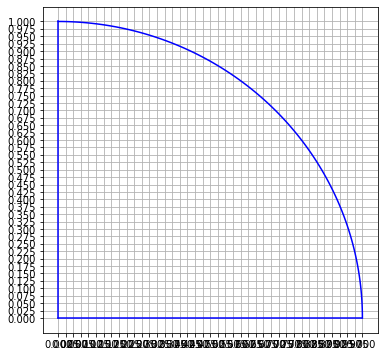

In [18]:
# Make grid
N = 40

x = np.linspace(0, 1, N+1)
y = np.linspace(0, 1, N+1) 

# Inner points
xi = x[1:-1]       
yi = y[1:-1] 
Xi, Yi = np.meshgrid(xi, yi)
Ni = N-1       # Number of inner points in each direction
Ni2 = Ni**2    # Number of inner points in total

t = np.linspace(0,np.pi/2,100)
ax, fig = plt.subplots(1, figsize=(6,6))
plt.plot(np.cos(t), np.sin(t), color='b')
plt.plot(x, np.zeros(N+1), color='b')
plt.plot(np.zeros(N+1), y, color='b')
plt.xticks(x)
plt.yticks(y)
plt.grid(b=True, which='major')
plt.show()

### Plot Results

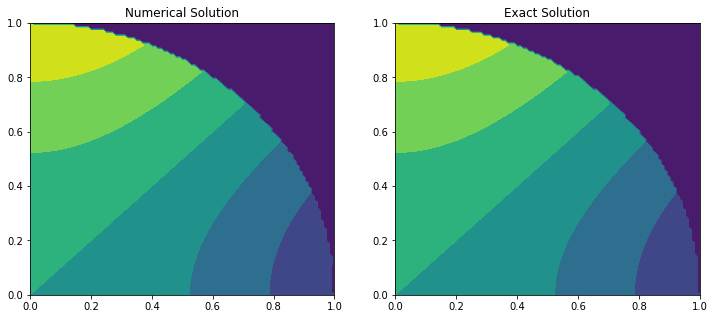

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
ax1.contourf(X, Y, U)
ax1.title.set_text('Numerical Solution')
ax2.contourf(X, Y, U_exact)
ax2.title.set_text('Exact Solution')

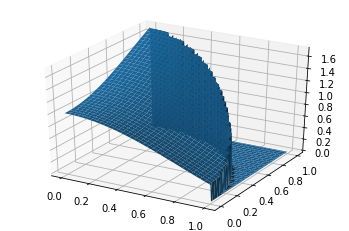

In [20]:
fig= plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, U)

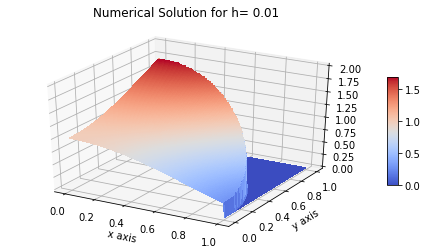

In [21]:
fig = plt.figure(figsize=plt.figaspect(0.5))

#===============
#  First subplot
#===============
# set up the axes for the first plot
ax = fig.add_subplot(1, 1, 1, projection='3d')

# plot a 3D surface like in the example mplot3d/surface3d_demo
surf = ax.plot_surface(X, Y, U, rstride=1, cstride=1, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_zlim(0, 2.0)
fig.colorbar(surf, shrink=0.5, aspect=10)
ax.title.set_text('Numerical Solution for h= ' + str(h))
ax.set_ylabel('y axis')
ax.set_xlabel('x axis')
plt.savefig('1c.pdf')

In [22]:

def convergence(P, N, mu=1, v1=0, v2=0):
    P = P   # Number of different stepsizes
    Hconv = np.zeros(P) #list of stepsizes (x-axis)
    Econv = np.zeros(P) #list of errors (y-axis)
    N = N  # The least number of intervals (#grid points-1)
    for p in range(P):
        U, U_exact, X, Y, h = pde_solve(N, mu)
        Eh = U_exact-U 
        Econv[p] = np.max(np.abs(Eh))
        Hconv[p] = h #the stepsize for y and x direction are the same
        N = N*2  # Double the number of intervals
    order = np.polyfit(np.log(Hconv),np.log(Econv),1)[0]   # Measure the order - returns highest power first
    return Hconv, Econv, order

2
6
The steplength is 1/4. The error is: 0.025765204824010235. Runtime total: 0.0035300254821777344
6
42
The steplength is 1/8. The error is: 0.013956109792445437. Runtime total: 0.004509925842285156
14
210
The steplength is 1/16. The error is: 0.006579899440932291. Runtime total: 0.008054018020629883
30
930
The steplength is 1/32. The error is: 0.0037513227313986097. Runtime total: 0.03584599494934082
62
3906
The steplength is 1/64. The error is: 0.0019500036572732693. Runtime total: 0.4934689998626709
126
16002
The steplength is 1/128. The error is: 0.0010408970751399904. Runtime total: 14.728761911392212
254
64770
The steplength is 1/256. The error is: 0.0004928032726193576. Runtime total: 442.68987703323364


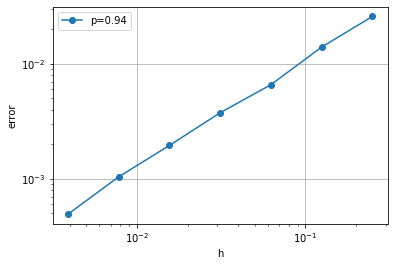

In [23]:
#convergence plot
H, E, p = convergence(7, 4)
plt.loglog(H,E,'o-', label='p={:.2f}'.format(p))
#plt.loglog(H,H*np.exp(1),'--',label='upper bound') # fyll inn upper bound (teoretisk her)
plt.grid('on')
plt.xlabel('h')
plt.ylabel('error')
plt.legend()
plt.savefig('1c_convergence.pdf')